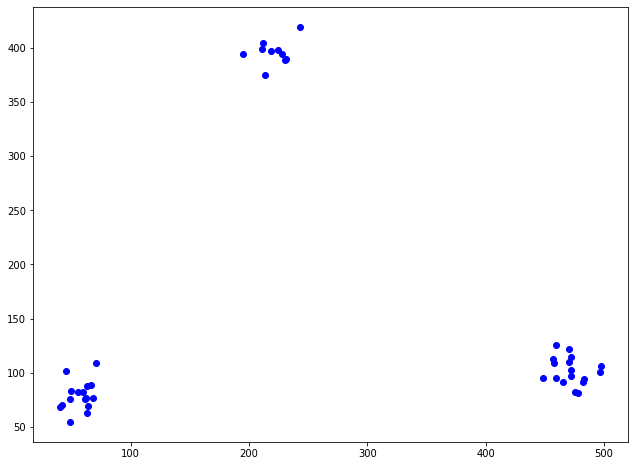

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pygame

points = np.empty((0,2), dtype='f')
    
c_radius = 3
c_color = (0,0,255)
c_thickness = 0 
jet_radius = 30
jet_thr = .9

bg_color = (255,255,255)
(width,height) = (640,480)
screen = pygame.display.set_mode((width,height))
pygame.display.set_caption("#5")

is_running = True
is_pushing = False
while is_running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            is_running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            is_pushing = True
        elif event.type == pygame.MOUSEBUTTONUP:
            is_pushing = False
            
    if is_pushing and np.random.uniform(0,1)>jet_thr:        
        (x, y) = pygame.mouse.get_pos()
        r = np.random.uniform(0,jet_radius)
        phi = np.random.uniform(0,2*np.pi)
        coord = [x+r*np.cos(phi), y+r*np.sin(phi)]
        points = np.append(points, [coord], axis=0)
            
    screen.fill(bg_color)
    for point in points:
        pygame.draw.circle(screen,c_color,(int(point[0]),int(point[1])),c_radius,c_thickness)
    pygame.display.flip()
    
pygame.quit()

fig = plt.figure(figsize=(width/60,height/60))
plt.scatter(points[:,0],points[:,1],c="blue")
plt.show()

In [8]:
class C_Means():
    def __init__(self, dataset, n_clusters=3, fuzzy=2, cut=.9):
        self.dataset = dataset
        self.n_clusters = n_clusters
        self.fuzzy = fuzzy
        self.cut = cut
        self.max_n_iter = 100
        self.tolerance = 1e-2
        self.fitted = False
        self.labels = np.array(np.empty(self.dataset.shape[0]), dtype='i')
        self.centroids = self.dataset[np.random.choice(self.dataset.shape[0], size=self.n_clusters, replace=False)]
        self.U = np.array([], dtype='f')
        
    def get_dist(self, list1, list2):
        return np.sqrt(sum((i-j)**2 for i,j in zip(list1,list2)))
    
    def distribute_data(self):
        dist = np.array([[self.get_dist(data,center) for center in self.centroids] for data in self.dataset])
        rev_dist = np.where(dist == 0., sys.maxsize, (1/dist)**self.fuzzy)
        self.U = rev_dist/rev_dist.sum(axis=1).reshape((rev_dist.shape[0],1))        
        
    def recalculate_centroids(self):
        for i in range(self.n_clusters):
            weight_sum = 0
            temp = np.zeros(self.dataset[0].shape)
            for k,weight in enumerate(self.U.T[i]):
                temp += self.dataset[k] * weight
                weight_sum += weight
            if (weight_sum != 0):
                self.centroids[i] = temp/weight_sum
        
    def get_labels(self):
        for i in range(self.dataset.shape[0]):
            if (np.max(self.U[i]) >= self.cut):
                self.labels[i] = np.argmax(self.U[i]) + 1
            else:
                self.labels[i] = 0
            
    def fit(self):
        iter = 0
        while iter < self.max_n_iter:
            prev_centroids = self.centroids.copy()
            self.distribute_data()
            self.recalculate_centroids()
            self.get_labels()
            if np.array([self.get_dist(i,j) for i,j in zip(prev_centroids,self.centroids)]).max()\
            < self.tolerance:
                break
            iter += 1
        self.fitted = True
        
    def predict(self, list2d):
        if not self.fitted:
            raise Exception("Can not receive lables if centroids were not calculated")
        dist = np.array([[self.get_dist(data,center) for center in self.centroids] for data in list2d])
        rev_dist = np.where(dist == 0., sys.maxsize, (1/dist)**self.fuzzy)
        local_U = rev_dist/rev_dist.sum(axis=1).reshape((rev_dist.shape[0],1)) 

        local_labels = np.array(np.empty(list2d.shape[0]), dtype='i')
        for i in range(list2d.shape[0]):
            if (np.max(local_U[i]) >= self.cut):
                local_labels[i] = np.argmax(local_U[i]) + 1
            else:
                local_labels[i] = 0
        return local_labels



<ipython-input-8-e8ff0a8bda5b>:19: RuntimeWarning: divide by zero encountered in true_divide
  rev_dist = np.where(dist == 0., sys.maxsize, (1/dist)**self.fuzzy)


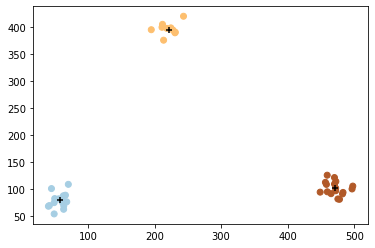

[0 0 3 0]


In [9]:
cmeans = C_Means(points)

cmeans.fit()

plt.scatter(points[:,0],points[:,1],c=cmeans.labels,cmap=plt.cm.Paired)
plt.scatter(cmeans.centroids[:,0],cmeans.centroids[:,1],c='black',marker='+')
plt.show()

print(cmeans.predict(np.array([[100, 350], [300, 200], [500, 100], [400, 175]])))